In [23]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import PIL
torch.cuda.is_available() 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from PIL import Image
import Helper
import numpy as np

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

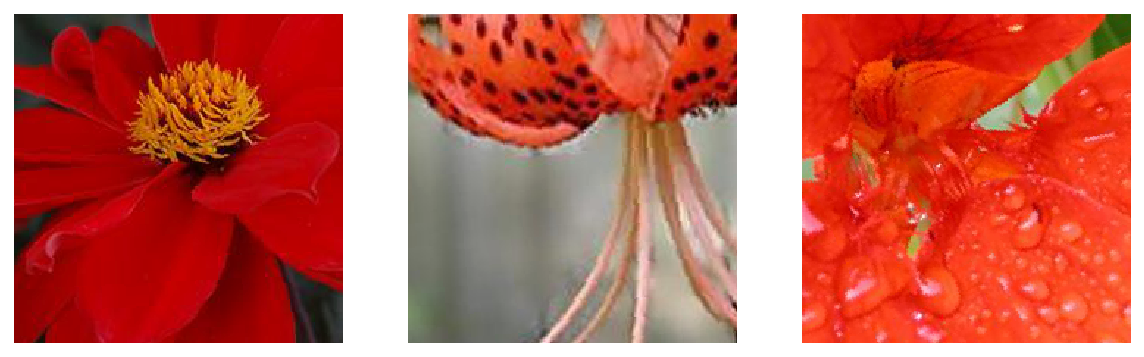

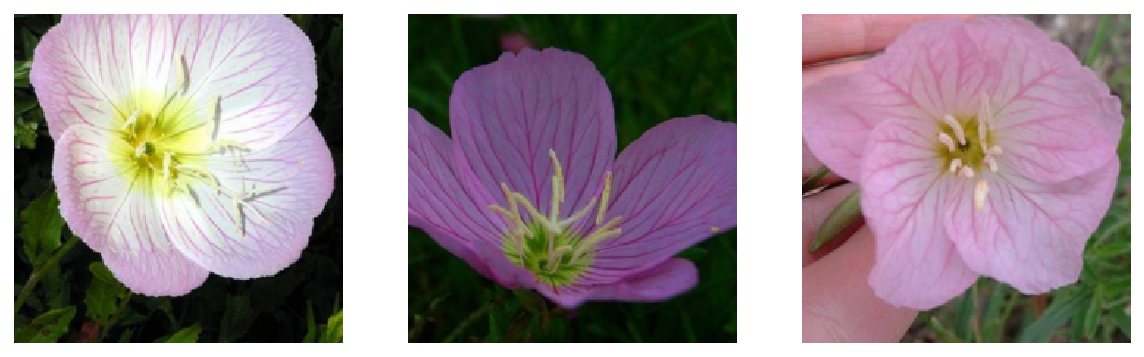

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms=
train_transforms=transforms.Compose([transforms.RandomRotation(30),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data=datasets.ImageFolder(data_dir +'/train',transform=train_transforms)
test_data=datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
#data_loaders=
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16,shuffle=False)
validloader= torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

#A test to see if I am loading the images correctly


images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=3)
for i in range(3):
    ax = axes[i]
    Helper.imshow(images[i], ax=ax)
    
images, labels = next(iter(testloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=3)
for i in range(3):
    ax = axes[i]
    Helper.imshow(images[i], ax=ax)

In [4]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
model.name='vgg'

for param in model.parameters():
    param.requires_grad = False
    
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
device = torch.device("cuda:0")



from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu',nn.ReLU()),
                          ('drop',nn.Dropout(0.5)),
                          ('fc2',nn.Linear(4096,102)),
                          ('softmax',nn.LogSoftmax(dim=1))]))
    
model.classifier = classifier
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
print(device)


cuda:0


In [5]:

# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

print_every=30
steps =0
print("Initialize training .....\n")
epochs = 5

for e in range(epochs):
    running_loss = 0
    model.train() 
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
     
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(testloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()
            
#My validation accuracy is really low... and it takes too long to run

Initialize training .....

Epoch: 1/5 |  Training Loss: 4.3401 |  Validation Loss: 3.9815 |  Validation Accuracy: 0.2103
Epoch: 1/5 |  Training Loss: 3.5107 |  Validation Loss: 3.3807 |  Validation Accuracy: 0.2656
Epoch: 1/5 |  Training Loss: 2.6668 |  Validation Loss: 2.9416 |  Validation Accuracy: 0.3185
Epoch: 1/5 |  Training Loss: 2.3339 |  Validation Loss: 2.6461 |  Validation Accuracy: 0.3962
Epoch: 1/5 |  Training Loss: 2.0207 |  Validation Loss: 2.4756 |  Validation Accuracy: 0.3914
Epoch: 1/5 |  Training Loss: 1.8872 |  Validation Loss: 2.3121 |  Validation Accuracy: 0.4527
Epoch: 1/5 |  Training Loss: 1.7023 |  Validation Loss: 2.1484 |  Validation Accuracy: 0.4599
Epoch: 1/5 |  Training Loss: 1.5476 |  Validation Loss: 2.2315 |  Validation Accuracy: 0.4271
Epoch: 1/5 |  Training Loss: 1.4424 |  Validation Loss: 1.9945 |  Validation Accuracy: 0.4892
Epoch: 1/5 |  Training Loss: 1.3860 |  Validation Loss: 1.9099 |  Validation Accuracy: 0.5337
Epoch: 1/5 |  Training Loss: 1.35

In [6]:
# TODO: Do validation on the test set
model.eval()
    
with torch.no_grad():
    _, accuracy = validation(model, testloader, criterion)
                
print("Test Accuracy on the model: {:.2f}%".format(accuracy*100/len(testloader)))

Test Accuracy on the model: 65.62%


In [15]:
model.class_to_idx = train_data.class_to_idx

checkpoint = {'classifier': model.classifier,
              'structure':model.name,
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
             }

torch.save(checkpoint, 'project_checkpoint.pth')

In [20]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint():
 
    checkpoint = torch.load("project_checkpoint.pth")
    
    model = models.vgg16(pretrained=True);
    
    # Freezing parameters
    for param in model.parameters(): param.requires_grad = False
    
    model.name = checkpoint['structure']
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict']
    )
    
    
    return model

# Loading it
model_cp =load_checkpoint()
                          
test_model(model_cp)   
#Not sure what is wrong here, but I cant test my model acordingly, any hints?

NameError: name 'test_model' is not defined

In [21]:
def process_image(image):

    test_image = PIL.Image.open(image)

   
    orig_width, orig_height = test_image.size

    
    if orig_width < orig_height: resize_size=[256, 256**600]
    else: resize_size=[256**600, 256]
        
    test_image.thumbnail(size=resize_size)

    
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

   
    np_image = np.array(test_image)/255 

    
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
 
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

In [22]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    
    
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

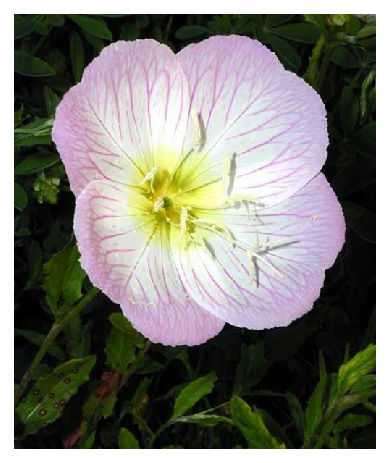

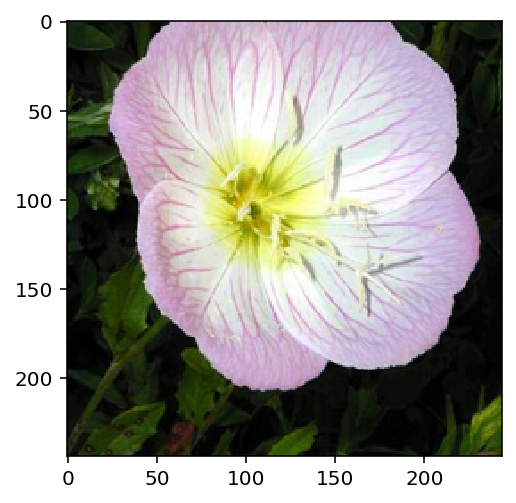

In [24]:
# Check reading image
import matplotlib.image as mpimg
im_path = 'flowers/test/1/image_06743.jpg'
img = mpimg.imread(im_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
# Test functions on an example
imshow(process_image('flowers/test/1/image_06743.jpg'));

In [27]:
def predict(image_path, model, top_k=5):
    
    model.to("cuda
    
    # Set model to evaluate
    model.eval();

   
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cuda

  
    log_probs = model.forward(torch_image)


    linear_probs = torch.exp(log_probs)

  
    top_probs, top_labels = linear_probs.topk(top_k)
    
    
    top_probs = np.array(top_probs.detach())[0] 
    top_labels = np.array(top_labels.detach())[0]
    
    
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

probs, classes = predict(im_path, model)
print(probs)
print(classes)
#Difficulties with class prediction

SyntaxError: EOL while scanning string literal (<ipython-input-27-b840fdd4fe2a>, line 3)

In [28]:
#Sanity check
imshow(process_image(im_path).numpy()[0])
plt.axis('off')

fig, ax = plt.subplots()
ax.barh(np.arange(5), probs)
ax.set_yticks(np.arange(5))
ax.set_yticklabels([model_cp.classifier.labelsdict[str(i + 1)] for c, i in \
                     model_cp.classifier.class_to_idx.items() if c in classes], size='small');
plt.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'